# Digital Insight Into Romantic Poetry: Positive vs Negative

## Yan Ren
08/19/2019

### Introduction

As an important literary genre, romanticism is full of vitality in the long river of history, especially in poetry. Romanticism impress people by its exaggeration and imagination. Just contrary to realism, Romanticism cares less about the reality and entities and mention more things with much subject modification. Undoubtedly, loads of differences could be observed between these two genres.

I'm more interesting about two branches of romanticism: positive romanticism and negative romanticism. Positive romanticism longs for a better future. Poets of this kind aims to encouraged people's morale and change the present into a better future. The ideal of positive romanticism is consistent with the trend of social development and with the wishes and demands of the masses. However, negative romanticists tend to glorify and reminisce about vanished social life and institutions in the hope that history can be retrogressed according to their wishes, so their thoughts are pessimistic, their emotions are sad, and their works are characterized by nostalgia, escapism, or mysticism. In art, the style is low, the color is dark, often covered with a layer of blurred trance, illusory veil. 

Are these statements true? Can we find some traits to tell the differences between them? In research of this question, I started the following process.

### Corpus Collecting

Considering the accuracy of the results, I selected 3 well-recognized representative poets for each side. I chose William Blake, Samuel Coleridge, William Wordsworth for negative romanticism, and George Gordon Byron, John Keats, Percy Bysshe Shelley for positive romanticism. Also, I collected my corpus on corpus-db.

In [3]:
import requests
import json
import nltk
import collections
import pandas as pd
import numpy as np
import spacy
import en_core_web_lg
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
from nltk.corpus import sentiwordnet as sw

In [4]:
nlp = en_core_web_lg.load()

In [5]:
def getTokens(lines):
    tokens = []
    for line in lines:
        lineDoc = nlp(line)
        tokens.extend([token.text.lower() for token in lineDoc if token.text.isalpha])
    return tokens

In [6]:
# get all information I need from one author
def getAuthorInf(name):
    authorInf = {}
    url = 'http://poetrydb.org/author/' + name
    text = requests.get(url).json()
    authorInf['content'] = [each['lines'] for each in text]
    authorInf['linecount'] = sum([int(text[i]['linecount']) for i in range(len(text))])
    authorInf['title'] = [each['title'] for each in text]
    authorInf['contentUnion'] = []
    for content in authorInf['content']:
        authorInf['contentUnion'].extend(content)
    return authorInf

In [7]:
# make the information of the lists of authors into one
def getAuthorUnionInf(nameList):
    authorUnionInf = {'content': [],
                     'title': [],
                     'contentUnion': [],
                     'linecount': 0}
    for name in nameList:
        authorInf = getAuthorInf(name)
        # 'content' save lines in different pieces seperately. But no seperation from different author
        authorUnionInf['content'].extend(authorInf['content'])
        # 'contentUnion' is just a collection of pure lines. No boundaries among pieces
        authorUnionInf['contentUnion'].extend(authorInf['contentUnion'])
        authorUnionInf['title'].extend(authorInf['title'])
        authorUnionInf['linecount'] += authorInf['linecount']
    return authorUnionInf

In [8]:
# Gather information of these two kinds
posNames = ['George Gordon, Lord Byron', 'John Keats', 'Percy Bysshe Shelley']
posInf = getAuthorUnionInf(posNames)
negNames = ['William Blake', 'Samuel Coleridge', 'William Wordsworth']
negInf = getAuthorUnionInf(negNames)

In [9]:
stops = nltk.corpus.stopwords.words('english')

### Hypotheses

The main idea is that noticeable differences can be observed between positive romanticism and negative romanticism.
- Positive romantic poets would use more and brighter color words in the lines of future, while negative romanticism would have darker color words about future but warmer colors about the past.
- Most used end rhymes can be different between these two kinds.
- Negative romanticism will gain higher grades in objectiveness and emotional fluctuation.

### Digital analysis I. Color Words Frequency

To test the hypothesis of positive romanticism’s optimistic about future and negative romanticism’s nostalgia about the past, I compared the color frequency in categories grouped by the tense and the genre (positive or negative)
-	The smallest calculation unit is the single line.
-	Figure out the tense of lines using a self-made function.
-	Find out the most frequently used color words and the ratio of total color word number to total word number of the whole text.
    - I used the built-in wordnet of nltk.
    - Attention: The ratio is not the ratio of the frequency of the most frequent words to total word number.

In [9]:
# categorize the lines into three tense
# return a dict of four keys: past, present, future, unknown
'''
VB     Verb, base form
VBD     Verb, past tense
VBG     Verb, gerund or present participle
VBN     Verb, past participle
VBP     Verb, non-3rd person singular present
VBZ     Verb, 3rd person singular present
'''
def classifyTenseOfLines(lines):
    pastPos = ['VBD', 'VBN']
    presentPos = ['VBG', 'VB', 'VBP', 'VBZ']
    futureWord = ['will', 'would', 'could', 'shall', 'won\'t', 'shan\'t']
    tenseLineDict = {'past': [], 'present':[], 'future':[], 'unknown':[]}
    
    for line in lines:
        conti = False
        tokens = nltk.word_tokenize(line)
        wordPos = nltk.pos_tag(tokens)
        words = [w[0] for w in wordPos]
        poses = [p[1] for p in wordPos]
        for pos in pastPos:
            if pos in poses:
                tenseLineDict['past'].append(line)
                conti = True
                break
        if conti:
            continue
        for word in futureWord:
            if word in words:
                tenseLineDict['future'].append(line)
                conti = True
        if conti:
            continue
        for pos in presentPos:
            if pos in poses:
                tenseLineDict['present'].append(line)
                conti = True
                break
        if conti:
            continue
        if not conti:
            tenseLineDict['unknown'].append(line)
    return tenseLineDict

In [10]:
negTense = classifyTenseOfLines(negInf['contentUnion'])
posTense = classifyTenseOfLines(posInf['contentUnion'])

In [11]:
colorNode = wn.synset('color.n.01')

In [12]:
def getDepthNHypernym(word, n):
    if word.max_depth() > n+1:
        if type(word.hypernyms()) is list and len(word.hypernyms()) > 0:
            return getDepthNHypernym(word.hypernyms()[0], n)
    return word.hypernyms()

In [13]:
def getLinesColor(lines):
    colorInText = []
    count = 1
    for line in lines:
        tokens = nltk.word_tokenize(line)
        count += len(tokens)
        for token in tokens:
            token = token.lower()
            syns = wn.synsets(token)
            for item in syns:
                if len(getDepthNHypernym(item, 5)) > 0:
                    if getDepthNHypernym(item, 5)[0] == colorNode:
                        colorInText.append(item._name.split('.')[0])
    return colorInText, len(colorInText)/count

In [14]:
# negative
negColorPastList, negColorPastN = getLinesColor(negTense['past'])
negColorPresentList, negColorPresentN = getLinesColor(negTense['present'])
negColorFutureList, negColorFutureN = getLinesColor(negTense['future'])
negMostColorPast = collections.Counter(negColorPastList).most_common(1)[0]
negMostColorPresent = collections.Counter(negColorPresentList).most_common(1)[0]
negMostColorFuture = collections.Counter(negColorFutureList).most_common(1)[0]

negMostColorWord = [negMostColorPast[0], negMostColorPresent[0], negMostColorFuture[0]]
negTenseColorCount = [negColorPastN, negColorPresentN, negColorFutureN]

In [15]:
# positive
posColorPastList, posColorPastN = getLinesColor(posTense['past'])
posColorPresentList, posColorPresentN = getLinesColor(posTense['present'])
posColorFutureList, posColorFutureN = getLinesColor(posTense['future'])
posMostColorPast = collections.Counter(posColorPastList).most_common(1)[0]
posMostColorPresent = collections.Counter(posColorPresentList).most_common(1)[0]
posMostColorFuture = collections.Counter(posColorFutureList).most_common(1)[0]

posMostColorWord = [posMostColorPast[0], posMostColorPresent[0], posMostColorFuture[0]]
posTenseColorCount = [posColorPastN, posColorPresentN, posColorFutureN]

In [17]:
negTenseColorCount = [-r for r in negTenseColorCount]

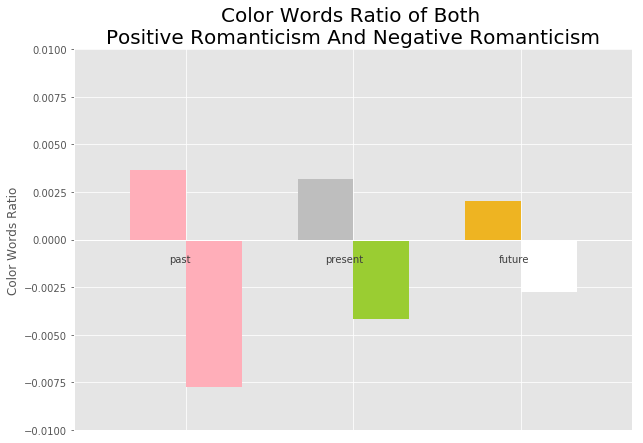

In [203]:
xlabel = ['past', 'present', 'future']
xmid = [1.0, 2.5, 4.0]
posx = [0.75, 2.25, 3.75]
negx = [1.25, 2.75, 4.25]
negMostColor = ['#FFAEB9', '#9ACD32', '#FFFFFF']
posMostColor = ['#FFAEB9', '#BEBEBE', '#EEB422']

fig, ax = plt.subplots(figsize = (10, 7))
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data', 0))
ax.yaxis.set_ticks_position('left')
plt.style.use('ggplot')
ax.set(ylim=[-0.01, 0.01], xlim = [0,5], xlabel='', 
       ylabel='Color Words Ratio') 
plt.title('Color Words Ratio of Both \nPositive Romanticism And Negative Romanticism', fontsize = 20)
plt.bar(posx, posTenseColorCount, width=0.5, color = posMostColor)
plt.bar(negx, negTenseColorCount, width=0.5, color = negMostColor)
ax.set_xticks(xmid)
ax.set_xticklabels(['','',''])
plt.annotate('past', xy = (0.85, -0.0012), color = '#3F3F3F')
plt.annotate('present', xy = (2.25, -0.0012), color = '#3F3F3F')
plt.annotate('future', xy = (3.80, -0.0012), color = '#3F3F3F');

In [19]:
negMostColorWord

['rose', 'green', 'white']

In [20]:
posMostColorWord

['rose', 'shade', 'amber']

I made a bar plot to visualize the results. Upward bars are positive romanticism groups, while downward ones represent their counterpart. X axis is about the tense and Y axis represent the color word ratio mentioned above. The colors in the bars are the most common colors used in different categories.
- Generally, negative romantic poets use more color words. These findings were really unexpected to me. I thought positive romanticism would use more words in every tense because they’re hopeful life, colors from their points of view can be more colorful. And I haven’t figure out a probable reason for this observation. 
- Both of them use most words of color while mentioning about the past and least of words talking about future. My hypothesis of this point is not accurate. Maybe it is a conventional distribution of the color word distribution grouped by the tense. And the difference between these two genre can’t disguise this trait of conventional poems.
- More specifically, color rose is most used both in positive romantic and negative romantic lines. As for present lines, positive romanticism uses more gray and negative romanticism uses more gray. Future about positive side looks as the most bright color in this graph, which is in consistent with my hypothesis in a way. The future of negative romanticism is white, not as gray as I once suspected, but not bright neither. 

### Digital Analysis II. Analysis of the End Rhymes

What distinguish poetry from other kinds of literature? Most people’s answer may be the rhymes. Among kinds of rhymes, end rhymes are the most common one. It sounds like that there’s no relationship between the end rhymes with what I’m study about. However, this process is reasonable and meaningful when it comes to the study of poems. Using the ```cmudict``` The results actually informed us of something.

In [21]:
arpabet = nltk.corpus.cmudict.dict()
allWords = arpabet.keys()

In [22]:
def getLastSound(line):
    line = line.lower()
    words = nltk.word_tokenize(line)
    words.reverse()
    lastWord = 0
    for word in words:
        if word.isalpha():
            lastWord = word
            break
    if lastWord not in allWords:
        return 0
    return arpabet[lastWord][-1][-1]

In [23]:
# get all of the rhythm sound of this collection of sounds
def getAllRhymeSound(lines):
    exceptionLines = []
    sounds = []
    for line in lines:
        sound = getLastSound(line)
        if sound == 0:
            exceptionLines.append(line)
        else:
            sounds.append(sound)
    return sounds, exceptionLines

In [24]:
posSounds, posExceptionLines = getAllRhymeSound(posInf['contentUnion'])
negSounds, negExceptionLines = getAllRhymeSound(negInf['contentUnion'])
posMostSounds = collections.Counter(posSounds).most_common(10)
negMostSounds = collections.Counter(negSounds).most_common(10)

In [55]:
negMostSoundsText = [s[0] for s in negMostSounds]
posMostSoundsText = [s[0] for s in posMostSounds]
negMostSoundsRatio = [s[1]/negInf['linecount']*100 for s in negMostSounds]
posMostSoundsRatio = [s[1]/posInf['linecount']*100 for s in posMostSounds]

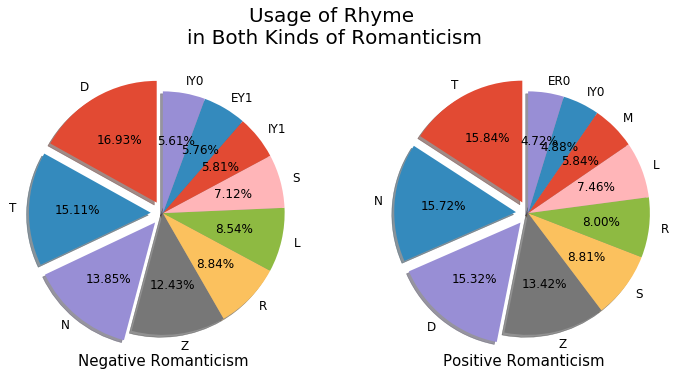

In [119]:
explode = [0.1, 0.1, 0.1] + [0] * 7
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
ax1.pie(negMostSoundsRatio, labels = negMostSoundsText, autopct='%1.2f%%', startangle=90, 
        explode=explode, shadow = True, textprops = dict(size = 12));
plt.annotate('Negative Romanticism', xy = (-0.7, -1.25), size = 15)
ax2 = plt.subplot(122)
ax2.pie(posMostSoundsRatio, labels = posMostSoundsText, autopct='%1.2f%%', startangle=90, 
        explode=explode, shadow = True, textprops = dict(size = 12));
plt.suptitle('Usage of Rhyme \nin Both Kinds of Romanticism', size = 20)
plt.annotate('Positive Romanticism', xy = (-0.7, -1.25), size = 15);

- The two different genres show the similar traits, which can be the regular conventions for composition of poems. For example, The last sounds of ‘T’, ‘D’, ‘N’ top both lists, Which was shown in the separation parts. The same trends were shown as well in the next following ranks. It helps us little to tell positive romanticism from negative romanticism, but it inspires us about the favorite end rhymes of poets.
- The distribution of the sounds is really similar. The pie chart looks exactly the same if you’re not observing carefully. There’s no such a dominant end rhyme in any of them. The distribution not a good trait to distinguish them.
- But if we look at the rhymes which rank lower, some differences can be detected. Sounds ‘M’ only appears in the top ranks of positive romanticism and ‘IY1’ only appears in the top 10 of negative romanticism. I suppose the sounds may include a specific projection of emotion?

### Digital Analysis III. Analysis of objectiveness and emotional fluctuation

This is the most interesting part to me. Take it literally, the most distinguishable trait can be the degree of objectiveness and emotional fluctuation. My hypothesis of this part is that negative romanticism may gain higher grades in both. It’s not backed up by a theory, just because I thought that if people are always missing the past, their emotion can change quite a lot when transferring the topic from their glittering past to the hopeless future.

How to measure and calculate about these kinds of abstract things? My method is based on three built-in functions in ```nltk.corpus.sentiwordnet```: ```obj_score()```, ```pos_score()```, ```neg_score()```. I just called objectiveness as the mean value of objective score of each line. As for emotional fluctuation, I added up the maximum ```pos_score``` and the maximum ```neg_score``` of each line, divided them by 2 to make sure the full mark is always 1, and calculated the mean value of lines of positive romanticism and negative romanticism separately.

In [27]:
def getScoresOfLine(line):
    '''
    This function return emotiona fluctuation and objectiveness grade
    We only interest in the grade of adjectives, adverbs and nouns
    '''
    posScores = []
    negScores = []
    objScores = []
    lineDoc = nlp(line)
    
    if len(line) > 0:
        for word in lineDoc:
            synPos =  word.pos_.lower()[0]
            if synPos in ['a', 'v', 'n']:
                synsets = list(sw.senti_synsets(word.lemma_, synPos))
                if (type(synsets) == list) and len(synsets)>0:
                    synset = synsets[0]
                    posScores.append(synset.pos_score())
                    negScores.append(synset.neg_score())
                    objScores.append(synset.obj_score())
        if len(posScores) > 0 and len(objScores) > 0:
            rangeScore = (max(posScores) + max(negScores))/2
            objScore = sum(objScores)/len(objScores)
            return rangeScore, objScore
        elif len(posScores) > 0 and len(objScores) == 0:
            return (max(posScores) + max(negScores))/2, 0
        elif len(posScores) == 0 and len(objScores) > 0:
            return 0, sum(objScores)/len(objScores)
        else:
            return 0, 0
    else:
        return 0, 0

In [130]:
def getScoresOfLines(lines):
    emotionOfLines = [getScoresOfLine(line)[0] for line in lines]
    objOfLines = [getScoresOfLine(line)[1] for line in lines]
    return emotionOfLines, objOfLines

In [131]:
negEmotion, negObj = getScoresOfLines(negInf['contentUnion'])

In [132]:
posEmotion, posObj = getScoresOfLines(posInf['contentUnion'])

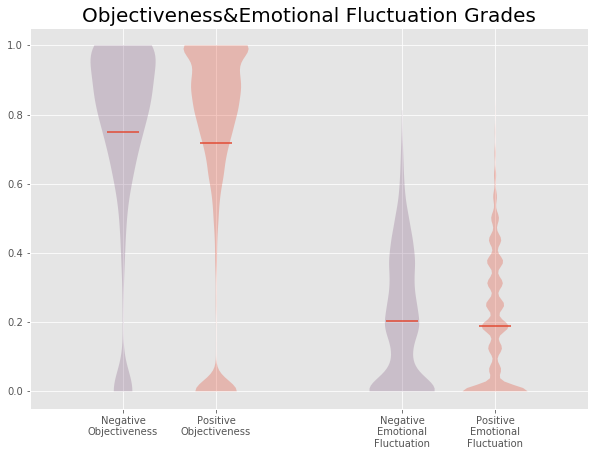

In [202]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
pc = ax.violinplot([negObj, posObj, negEmotion, posEmotion], showmeans=True,
    showextrema=False,
    showmedians=False,positions = [1, 2, 4, 5], widths = 0.7
);
ax.set_xlim([0, 6])
ax.set_xticks([1, 2, 4, 5])
ax.set_xticklabels(['Negative\nObjectiveness', 'Positive\nObjectiveness', 
                    'Negative\nEmotional\nFluctuation', 'Positive\nEmotional\nFluctuation'])
pc['bodies'][0].set_facecolor("#8B668B")
pc['bodies'][2].set_facecolor("#8B668B")
plt.title('Objectiveness&Emotional Fluctuation Grades', fontsize = 20);

I’ve made a violin plot to visualize it to show the distributions of these four sets of calculated data. The red lines represent the mean values. The lighted red and purple bodies represent the data distributions of positive romanticism and negative romanticism. As the x-ticks label suggests, the left pair of figure is about objectiveness, and the other side is about emotional fluctuation. Another thing needs to pay attention to, I only grade about objectives, verbs, and nouns instead of calculating all grades of those words in line. I believe the style is most portrayed by these three kinds of words. Counting all will prolong the running time and not very accurate.

- I suppose that negative romanticism would gain higher grades in objectiveness and emotional fluctuation. This hypothesis is true according to this graph. Red lines of the purple bodies are always higher than those of red bodies. But the degrees are actually different. About the objectiveness, negative romanticism gains significantly higher. But when it comes to emotional fluctuation, the variance is just slight. The two water droplets shape things at the bottom of the graph mean the score is close to 0. Actually, Some lines have few words. In my function, I consider lines with no proper words get a score of 0. Once there are sufficient words, objectiveness grades cluster upwards, so I think the two drops can be ignored reasonably.
- Plotting like this, I’m surprised to find out some results about distributions of data, which is quite out of expectancy. The left pair looks the same, which means that the objective scores of each side distributes in the similar pattern. In the contrary, positive romanticism and negative romanticism varies a lot in the distribution of emotional fluctuation grades despite the close mean value. Negative romanticism’s emotional fluctuation distributes more evenly and the span is longer. Positive romanticism poets got grades which cluster in some points and the highest grade is also much smaller than its counterpart. It inspires me about the emotional state differences. Maybe the discrete points of grades of emotional fluctuation is where positive romantic poets feel easy and used to. However, negative romantic poets vary more in emotion, they feel more free to write lines of any emotional fluctuation.

### Application of the findings

After research about the difference between positive romanticism and negative romanticism seriously, it’s time to do something funny on this topic.
- Use another poet’ s poets, we can predict which genre he/she is in. Or if this poet lives in not the same periods with the six poets I selected, we can use the results to decide which genre influence him/her more.
- You can write a romantic poem by yourself! And use the result to find out you’re more like positive romantic poets or negative romantic poets.

These two functions are the same in essence. They’re all about compare the style of the poems with these two genres. There’re many ways to make these applications come true. One way is to compare the three aspects I studied about above, and just use the traits of each graph to predict about. One of another way is to use more accurate built-in function in ```nltk```, which would be shown here.

In [30]:
def similarity(a, b):
    return nlp(a).similarity(nlp(b))

In [33]:
'''
a function to get the grade of similarity of the input lines and two kinds of romanticism
returns 2 grades as a dictionary.
Attention: Because of limitation of the code, I only use a sample of positive romanticism to be in the ```nlp()```
'''
def getSimGrades(lines):
    grades = {'pos':0, 'neg':0}
    posSample = [posInf['contentUnion'][i] for i in range(0, len(negInf['contentUnion']), 41)]
    grades['pos'] = similarity(' '.join(posSample), lines)
    grades['neg'] = similarity(' '.join(negInf['contentUnion']), lines)
    return grades

In [37]:
def guessClass(lines):
    grades = getSimGrades(lines)
    if grades['pos'] > grades['neg']:
        return 'positive romanticism'
    elif grades['neg'] > grades['pos']:
        return 'negative romanticism'
    else:
        return 'you wrrte like both of them'

In [38]:
unknown = "APRIL is the cruellest month, breeding Lilacs out of the dead land, mixing Memory and desire, stirring	Dull roots with spring rain. Winter kept us warm, covering Earth in forgetful snow, feeding A little life with dried tubers. Summer surprised us, coming over the Starnbergersee With a shower of rain; we stopped in the colonnade,  And went on in sunlight, into the Hofgarten, And drank coffee, and talked for an hour. Bin gar keine Russin, stamm’ aus Litauen, echt deutsch.	 And when we were children, staying at the archduke’s, My cousin’s, he took me out on a sled, And I was frightened. He said, Marie, Marie, hold on tight. And down we went. In the mountains, there you feel free. I read, much of the night, and go south in the winter."

In [39]:
guessClass(unknown)

'negative romanticism'

This is actually an excerpt from Thomas Stearns Eliot's poems. As we know, he is a British poet as well, but he lived in a relatively recent period compared with the 6 poets I selected to study with. Was he more influenced by positive romanticism or negative romanticism?

The result is that negative romanticism influenced him more than positive romanticism. Because his style is more like negative romanticism according to the ```similarity()``` function in ```spacy```. If the instance gets the same grade of the similarity with positive and negative romanticism, this function can't differentiate one from the other.

### Conclusion

Aiming to differentiate positive romanticism from negative romanticism, I did some operation on color word frequency, end rhymes, objectiveness and emotional fluctuation. They show some traits really familiar with each other because they’re both romanticism. They also have other characteristics different from each other.

My main hypothesis: “Noticeable differences can be observed between positive romanticism and negative romanticism.” Is basically true. But the sub-hypotheses are not totally right or wrong. Some unexpected observations did happen, and the application is funny as well.

### Citation

[1]Justus Conrad Gronau. The Soul in British Romanticism: Negotiating Human Nature in Philosophy, Science, and Poetry[J]. Zeitschrift für Anglistik und Amerikanistik,2016,64(4).

[2]Ting Wang.Positive Romanticism and Ode to the West Wind[J].Haiwai English,2011(01):224+226.